In [1]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs --break-system-packages
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO --break-system-packages

In [2]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO

In [3]:
# !pip install -e ../../objFuncs
# !pip install -e ../../pyBO

# large decision bound was essential!

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from copy import deepcopy as copy

/home/devuser/.local/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [5]:
import objFuncs
from objFuncs import VM
from objFuncs import residuals
from objFuncs.util import plot_obj_history, plot_multi_obj_history, plot_time_val
from objFuncs import flame_utils_kilean as flame_utils

objFuncs version: 1.0.3. updated on 2024-03-11


In [6]:
latfile = "../objFuncs/FLAME_lat/test_FS1d_20231130_040841_read.lat"

In [7]:
decision_CSETs=['FS1_CSS:PSC2_D2351', 'FS1_CSS:PSC2_D2367']
decision_min = -20
decision_max =  20

In [8]:
objective_goal = { 
    'FS1_CSS:BPM_D2383:XPOS_RD' : 0.0,
    'FS1_BBS:BPM_D2421:XPOS_RD' : 0.0,
    'FS1_BBS:BPM_D2466:XPOS_RD' : 0.0,
}
objective_norm = {pv:1.0 for pv in objective_goal.keys()}
objective_weight = {pv:1.0 for pv in objective_goal.keys()}
objective_RDs = list(objective_goal.keys())

conditional_SETs = {
    'FS1_CSS:PSQ_D2372:I_CSET':[],
    'FS1_CSS:PSQ_D2377:I_CSET':[],
}

In [9]:
fm_vm = flame_utils.VM(
        latfile = latfile,
        decision_CSETs = list(conditional_SETs.keys()),
        objective_RDs  = objective_RDs,)
fm = fm_vm.fm
fm.zero_orbtrim()

n_condition = len(conditional_SETs)

for i,k in enumerate(conditional_SETs.keys()):
    fm_vm.x0[i] = round(fm_vm.x0[i], 2)
    conditional_SETs[k] = [fm_vm.x0[i]]*n_condition
    conditional_SETs[k][1] += 20

for k, v in conditional_SETs.items():
    print(k,v)

FS1_CSS:PSQ_D2372:I_CSET [54.38, 74.38]
FS1_CSS:PSQ_D2377:I_CSET [36.79, 56.79]


In [10]:
Quads = fm.get_df_by_type('quadrupole')
misalign = pd.read_csv('../objFuncs/data/FRIB As-Aligned Component Positions.csv')

new_misalign = []

for name in Quads['name']:
    name_ = name.replace('QH','QV')
    i = misalign[misalign['Name'] == name_].index
    if len(i) == 0:
        name_ = name.replace('QV','QH')
        i = misalign[misalign['Name'] == name_].index
    i = i[0]
    new_misalign.append(misalign.loc[i]) 
    
misalign = pd.DataFrame(new_misalign)
misalign.rename(columns={'Name': 'name'},inplace=True)
misalign.index = Quads.index

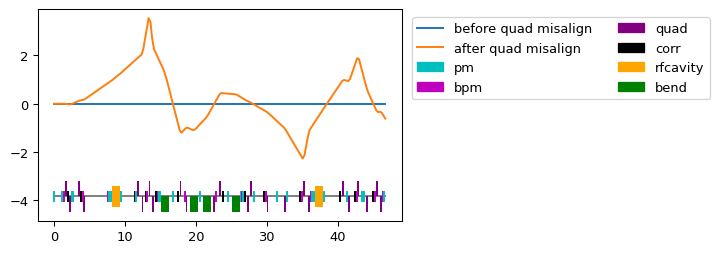

In [11]:
r,s = fm.run(monitor='all')
r0 = fm.collect_data(r,'pos','xcen','ycen','xrms','yrms')

Quads['dx'] = misalign['Horz_Off_Meters'].values
Quads['dy'] = misalign['Vert_Off_Meters'].values
Quads['pitch'] = misalign['Pitch_R1_Deg'].values/180*np.pi
Quads['roll'] = misalign['Roll_R2_Deg'].values/180*np.pi
Quads['yaw'] = misalign['Yaw_R3_Deg'].values/180*np.pi

for i in Quads.index:
    fm.reconfigure(i,{'dx':Quads['dx'].loc[i]})
    fm.reconfigure(i,{'dy':Quads['dy'].loc[i]})
    fm.reconfigure(i,{'pitch':Quads['pitch'].loc[i]})
    fm.reconfigure(i,{'roll':Quads['roll'].loc[i]})
    fm.reconfigure(i,{'yaw':Quads['yaw'].loc[i]})
    
r,s = fm.run(monitor='all')
r1 = fm.collect_data(r,'pos','xcen','ycen','xrms','yrms')

plotlat = flame_utils._plot_lattice(fm.machine)
fig,ax = plt.subplots(figsize=(5,3),dpi=94)
ax.plot(r0['pos'],r0['xcen'],label='before quad misalign')
ax.plot(r0['pos'],r1['xcen'],label='after quad misalign')
ymin,ymax = ax.get_ylim()
plotlat(ax=ax,ymin=ymin,ymax=ymax)

In [12]:
fm_vms = []
for i in range(n_condition):
    fm_vm = flame_utils.VM(
            latfile = latfile,
            decision_CSETs = decision_CSETs,
            objective_RDs  = objective_RDs,
            conditional_SETs = {key:val[i] for key, val in conditional_SETs.items()},
        )
    fm = fm_vm.fm
    fm.zero_orbtrim()
    # add quad misalignment
    for i in Quads.index:
        fm.reconfigure(i,{'dx':Quads['dx'].loc[i]})
#     m0 = copy(fm_vm.fm.bmstate.moment0)
#     m0[0] = 2.
#     fm_vm.fm.bmstate.moment0 = m0
    fm_vms.append(fm_vm)

In [13]:
machineIO_vms = []
for fm_vm in fm_vms:
    machineIO_vms.append(
        VM(
            x0 = fm_vm.x0,
            fun = fm_vm,
            decision_CSETs = decision_CSETs,
            objective_RDs = objective_RDs,
            fetch_data_time_span = 0.2,
        )
    )

In [14]:
BPMnames = [pv.replace(':XPOS_RD','') for pv in objective_RDs]
BPMs = fm.get_df_by_type('bpm')
BPMs = BPMs[BPMs['name'].isin(BPMnames)]
BPMs

,type,name,z,L
index,,,,
82,bpm,FS1_CSS:BPM_D2383,14.587727,0.0
103,bpm,FS1_BBS:BPM_D2421,18.403514,0.0
123,bpm,FS1_BBS:BPM_D2466,22.884765,0.0


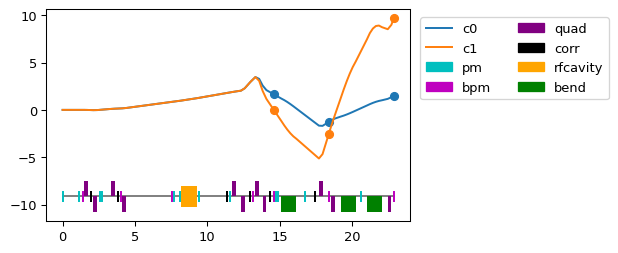

In [15]:
r0 = []
for fm_vm in fm_vms:
    r,s = fm_vm.fm.run(monitor='all',to_element=fm_vm.last_elem_index)
    r0.append( fm_vm.fm.collect_data(r,'pos','xcen','ycen') )

fig,ax = plt.subplots(figsize=(5,3),dpi=94)
for i,r0_ in enumerate(r0):
    ax.plot(r0_['pos'],r0_['xcen'],label='c'+str(i))
    ax.scatter(r0_['pos'][BPMs.index],r0_['xcen'][BPMs.index])
fm_vm.fm.plot_lattice(end=fm_vm.last_elem_index+1,ax=ax,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1])

In [16]:
objFuncs._global_machineIO._fetch_data = machineIO_vms[0].fetch_data
objFuncs._global_machineIO._ensure_set = machineIO_vms[0].ensure_set
objFuncs._global_machineIO._test = True

In [17]:
res = residuals.residualObjMultiConditionalVar(  
    decision_CSETs = decision_CSETs,
    decision_min= decision_min,
    decision_max= decision_max,
    objective_goal = objective_goal,
    objective_norm = objective_norm,
    objective_weight = objective_weight,
    conditional_SETs = conditional_SETs,
    var_obj_weight_fraction = 1.0,
    )

for i in range(n_condition):
    machineIO = objFuncs.construct_machineIO()
    machineIO._fetch_data  = machineIO_vms[i].fetch_data
    machineIO._ensure_set  = machineIO_vms[i].ensure_set
    machineIO._test = True
    res.residualObj[i].machineIO = machineIO

======== class info ========
init_time: 2024-03-13 13:17:47.013243
class_hierarchy: [
    residualObjMultiConditionalVar, residualObjMultiConditional, objFuncBase]
decision_CSETs: [
    FS1_CSS:PSC2_D2351, FS1_CSS:PSC2_D2367]
decision_min: [-20. -20.]
decision_max: [20. 20.]
decision_bounds: [[-20.  20.]
 [-20.  20.]]
decision_RDs: [
    FS1_CSS:PSC2_D2351, FS1_CSS:PSC2_D2367]
decision_tols: None
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: 
logging_fname: None
x0: [
    0.0, -1.41633]

[condition_controller] ======== class info ========
init_time: 2024-03-13 13:17:47.091771
class_hierarchy: [
    objFuncBase]
decision_CSETs: [
    FS1_CSS:PSQ_D2372:I_CSET, FS1_CSS:PSQ_D2377:I_CSET]
decision_min: [54.38 36.79]
decision_max: [74.38 56.79]
decision_bounds: [[54.38 74.38]
 [36.79 56.79]]
decision_RDs: [
    FS1_CSS:PSQ_D2372:I_RD, FS1_CSS:PSQ_D2377:I_RD]
decision_tols: None
decision_couplings: None
history_buffer_size: None
logging_frequency: inf


In [18]:
plot_decisions = plot_obj_history(
    res.history['decision_RDs'],
    title='decision_RDs',
)

plot_control = plot_obj_history(
    res.condition_controller.history['decision_CSETs'],
    title='condition controller',
)

plot_conditions_RDs = plot_multi_obj_history(
    histories = [res.history['condition'+str(i)]['objective_RDs'] for i in range(n_condition)],
    history_labels = ['C'+str(i) for i in range(n_condition)],
    title='multi-condition_obj_RDs',
)
plot_objectives_var = plot_obj_history(
    res.history['objectives_var'],
    title='objectives_var',
)

class add_delay:
    def __init__(self):
        pass
    def __call__(self):
        time.sleep(5)
    def close(self):
        pass
    
add_delay = add_delay()
    
callbacks = [add_delay,plot_decisions,plot_conditions_RDs,plot_objectives_var,add_delay]
# callbacks = []

# runLSQ

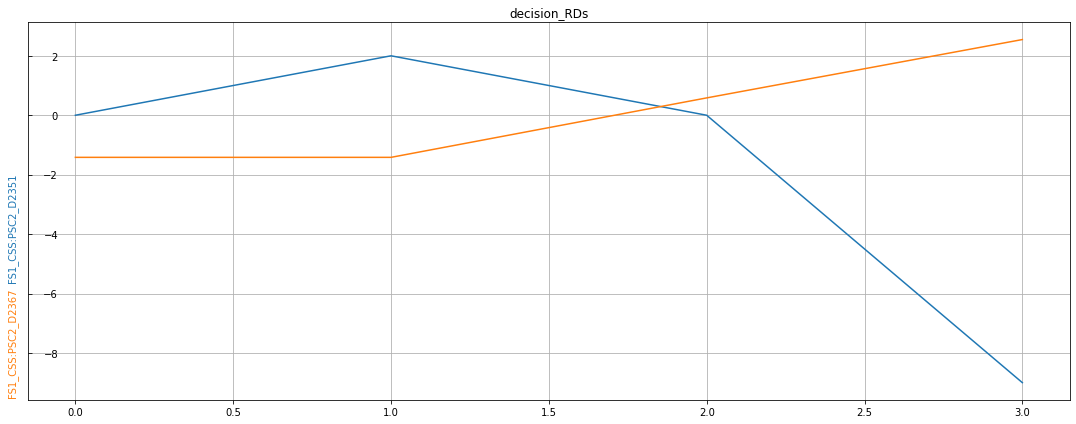

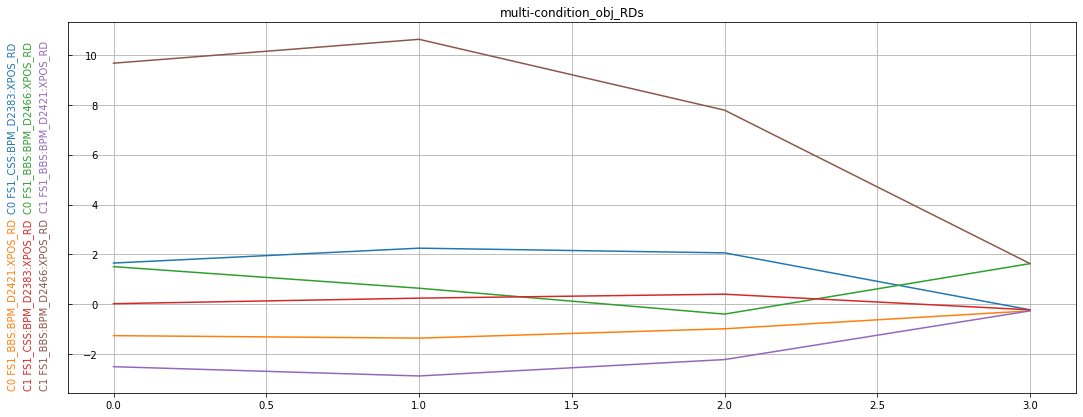

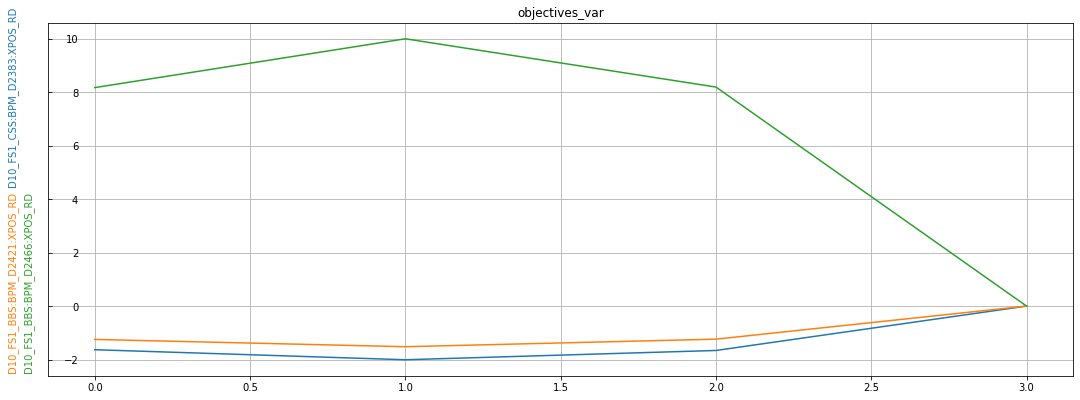

In [19]:
result = res.lsq_linear(jac_use3points=False,callbacks=callbacks)
for f in callbacks:
    f.close()

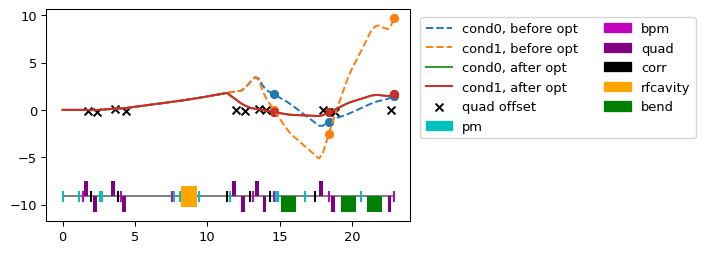

In [20]:
r1 = []
for fm_vm in fm_vms:
    r,s = fm_vm.fm.run(monitor='all',to_element=fm_vm.last_elem_index)
    r1.append( fm_vm.fm.collect_data(r,'pos','xcen','ycen') )

fig,ax = plt.subplots(figsize=(5,3),dpi=94)
i=0
for r0_, r1_ in zip(r0,r1):
    ax.plot(r0_['pos'],r0_['xcen'],'--',label='cond'+str(i)+', before opt')
    ax.scatter(r0_['pos'][BPMs.index],r0_['xcen'][BPMs.index])
    i+=1
i=0
for r0_, r1_ in zip(r0,r1):
    ax.plot(r1_['pos'],r1_['xcen'],label='cond'+str(i)+', after opt')
    ax.scatter(r1_['pos'][BPMs.index],r1_['xcen'][BPMs.index])
    i+=1

ax.scatter(r0_['pos'][Quads.index[:11]],Quads['dx'][:11]*1e3,marker='x',color='k',label='quad offset')
    
fm_vm.fm.plot_lattice(end=fm_vm.last_elem_index+1,ax=ax,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1])

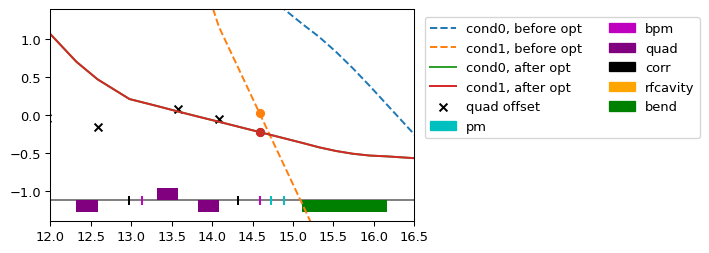

In [21]:
r1 = []
for fm_vm in fm_vms:
    r,s = fm_vm.fm.run(monitor='all',to_element=fm_vm.last_elem_index)
    r1.append( fm_vm.fm.collect_data(r,'pos','xcen','ycen') )

fig,ax = plt.subplots(figsize=(5,3),dpi=94)
i=0
for r0_, r1_ in zip(r0,r1):
    ax.plot(r0_['pos'],r0_['xcen'],'--',label='cond'+str(i)+', before opt')
    ax.scatter(r0_['pos'][BPMs.index],r0_['xcen'][BPMs.index])
    i+=1
i=0
for r0_, r1_ in zip(r0,r1):
    ax.plot(r1_['pos'],r1_['xcen'],label='cond'+str(i)+', after opt')
    ax.scatter(r1_['pos'][BPMs.index],r1_['xcen'][BPMs.index])
    i+=1

ax.scatter(r0_['pos'][Quads.index[:11]],Quads['dx'][:11]*1e3,marker='x',color='k',label='quad offset')
ax.set_xlim(12,16.5)
ax.set_ylim(-1.4,1.4)
    
fm_vm.fm.plot_lattice(end=fm_vm.last_elem_index+1,ax=ax,ymin=-0.8,ymax=0.8)

In [22]:
res.history['decision_CSETs']

{'names': ['FS1_CSS:PSC2_D2351', 'FS1_CSS:PSC2_D2367'],
 'values': [array([ 0.     , -1.41633]),
  array([ 2.     , -1.41633]),
  array([0.     , 0.58367]),
  array([-8.9953826 ,  2.54628931])]}

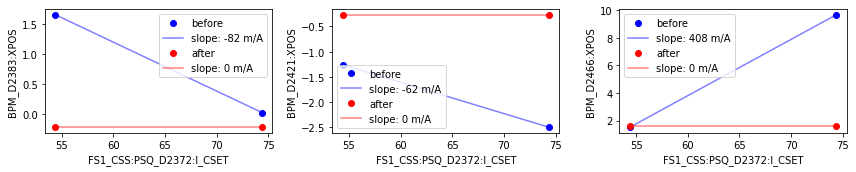

In [23]:
nobj = len(objective_goal)
condition_label, condition_vals = list(conditional_SETs.items())[0]
fig,ax = plt.subplots(1,nobj,figsize=(4*nobj,2.5))

ylims = []
for iobj in range(nobj):
    values = []
    for icond in range(n_condition):
        values.append(res.history['condition'+str(icond)]['objective_RDs']['values'][0][iobj])
    ax[iobj].plot(condition_vals,values,'o',color='b',label='before')
    p = np.polyfit(condition_vals,values,deg=1)
    ax[iobj].plot(condition_vals,p[0]*np.array(condition_vals)+p[1],color='b',alpha=0.5,label='slope: '+str(round(p[0]*1000))+' m/A')
    
    values = []
    for icond in range(n_condition):
        values.append(res.history['condition'+str(icond)]['objective_RDs']['values'][-1][iobj])
    ax[iobj].plot(condition_vals,values,'o',color='r',label='after')
    p = np.polyfit(condition_vals,values,deg=1)
    ax[iobj].plot(condition_vals,p[0]*np.array(condition_vals)+p[1],color='r',alpha=0.5,label='slope: '+str(round(p[0]*1000))+' m/A')
    ax[iobj].legend()
    ax[iobj].set_xlabel(condition_label)
    ylabel = objective_RDs[iobj]
    ylabel = ylabel[ylabel.find(':')+1:-3]
    ax[iobj].set_ylabel(ylabel)
    
fig.tight_layout()